Copyright 2021 Amazon.com and its affiliates; all rights reserved. This file is AWS Content and may not be duplicated or distributed without permission

# Amazon SageMaker Feature Store Monitoring

### Contents

1. [Generate synthetic data for housing models](#Generate-synthetic-data-for-housing-models)
1. [Clean up](#Clean-up)

#### Feature monitoring with SageMaker Feature Store
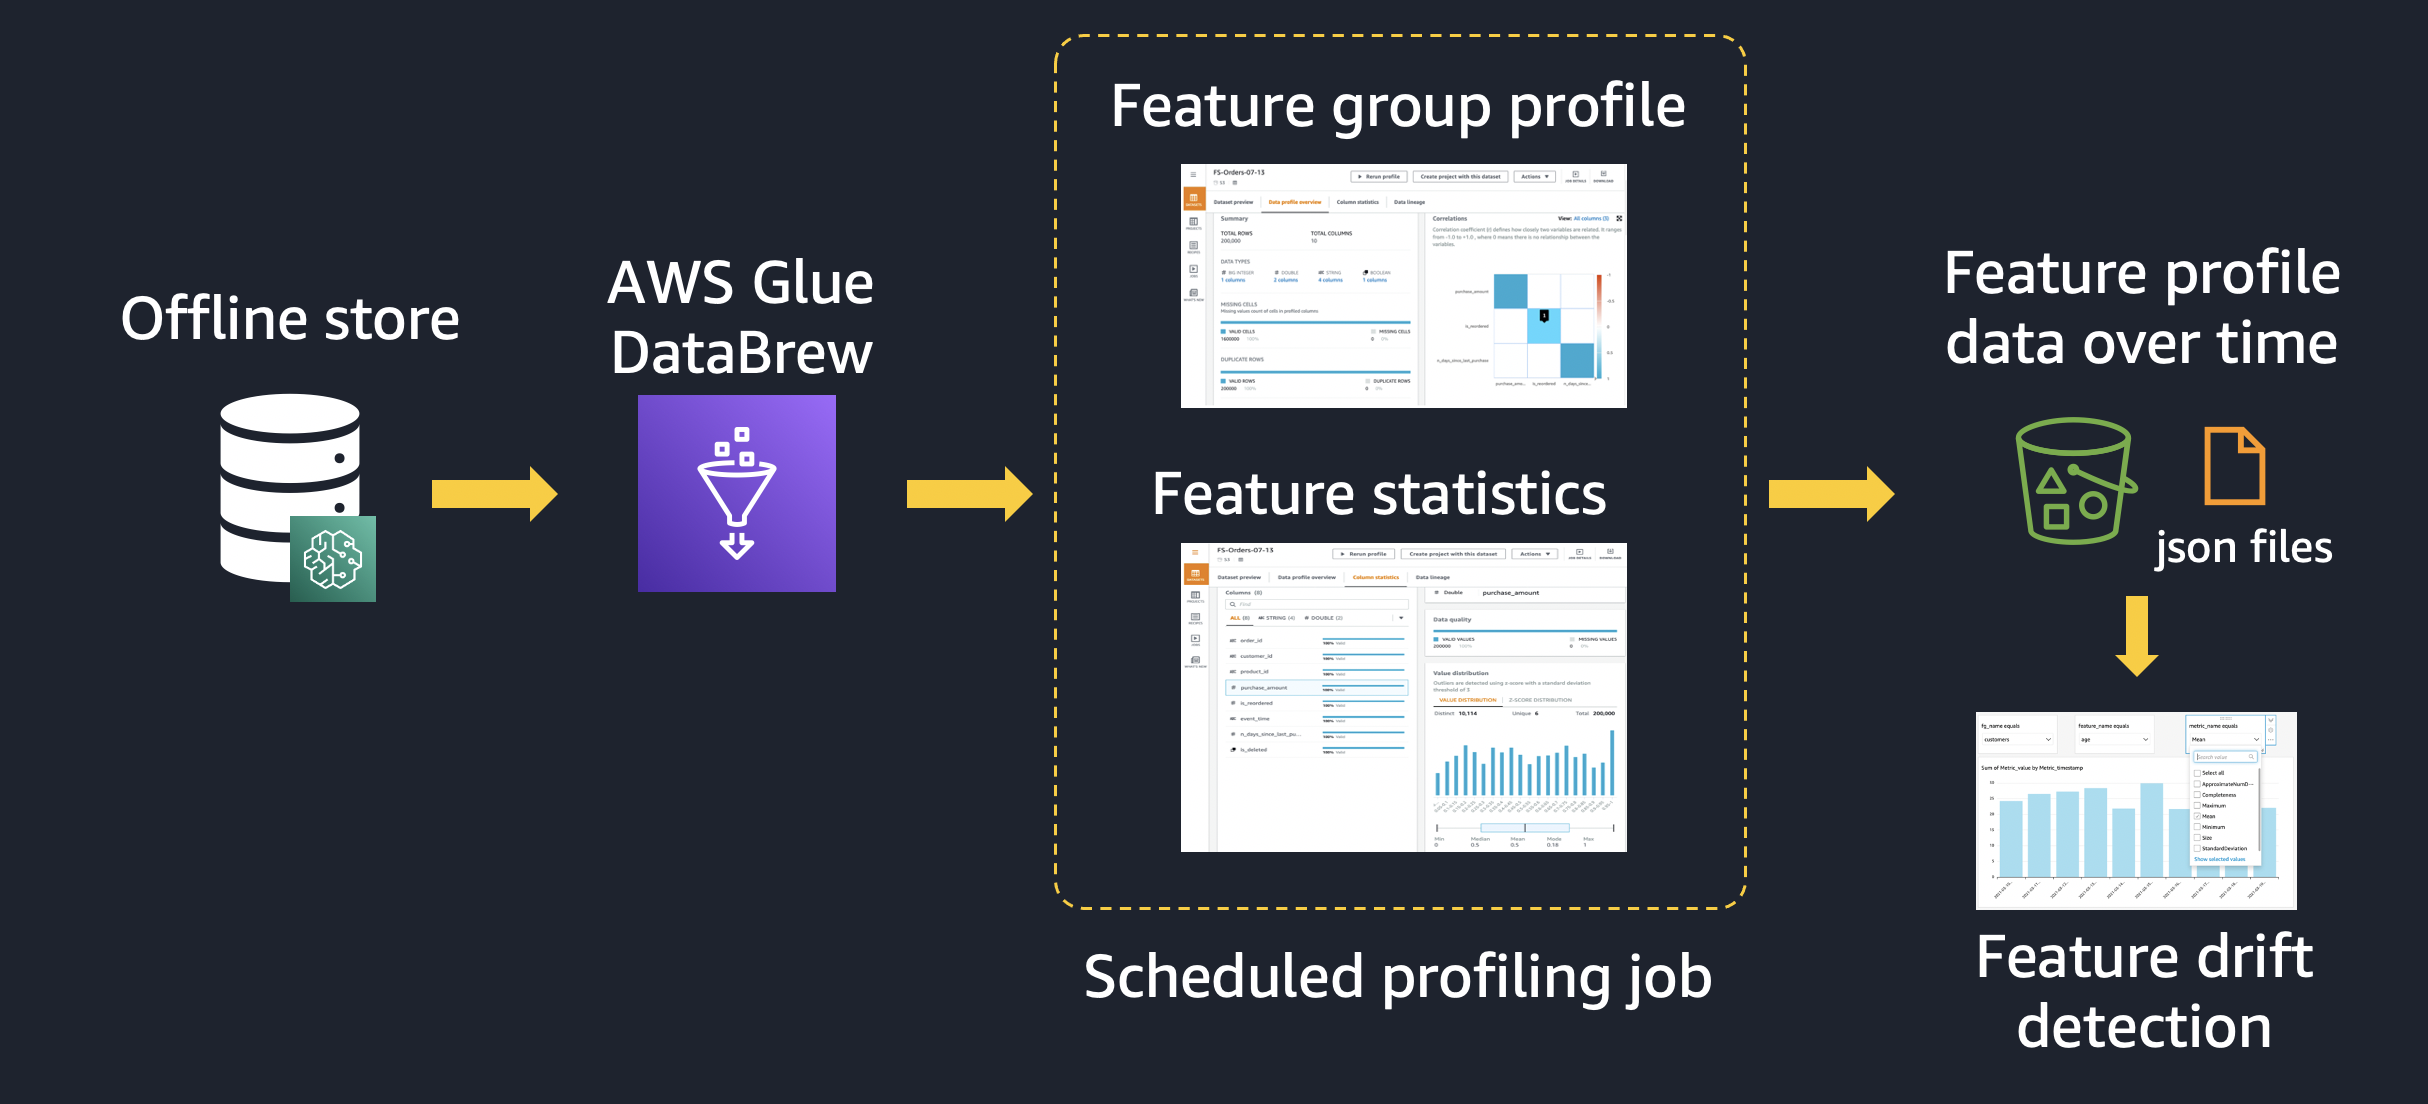

# Generate synthetic data

The code below contains helper functions to generate synthetic data in the form of a `1x7` numpy array representing the features of a house.

The first entry in the array is the randomly generated price of a house. The remaining entries are the features (i.e. number of bedroom, square feet, number of bathrooms, etc.).

These functions will be used to generate synthetic data for training, validation, and testing. It will also allow us to submit synthetic payloads for inference to test our multi-model endpoint.

In [ ]:
# !pip install -Uq sagemaker

In [ ]:
!pip install pyathena

In [ ]:
# !pip install --upgrade pandas

In [ ]:
import sagemaker
print(sagemaker.__version__)

In [ ]:
from utilities.feature_store_helper import FeatureStore

import numpy as np
import pandas as pd
import time
from IPython.display import display, Markdown
from datetime import datetime, timezone

FG_NAME = 'fs-demo-2022-03-24'

fs = FeatureStore()

In [ ]:
import utilities.feature_monitoring_utils as feature_monitoring_utils

In [ ]:
results_bucket=sagemaker.Session().default_bucket() 
results_key='feature-monitor/housing-reports'

In [ ]:
s3_loc = f's3://{results_bucket}/{results_key}'
!aws s3 ls $s3_loc/

In [ ]:
NUM_HOUSES_PER_LOCATION = 10000
LOCATIONS = [
    "NewYork_NY",
    "LosAngeles_CA",
    "Chicago_IL",
    "Houston_TX",
    "Dallas_TX",
    "Phoenix_AZ",
    "Philadelphia_PA",
    "SanAntonio_TX",
    "SanDiego_CA",
    "SanFrancisco_CA",
]
MAX_YEAR = 2019

In [ ]:
def gen_price(house):
    jitter = 1 - np.random.uniform(-0.03, 0.03)

    _base_price = max(150000, int(house["SQUARE_FEET"] * 150))
    _price = int(
        _base_price
        + (10000 * jitter * house["NUM_BEDROOMS"])
        + (15000 * jitter * house["NUM_BATHROOMS"])
        + (15000 * jitter * house["LOT_ACRES"])
        + (15000 * jitter * house["GARAGE_SPACES"])
        - (5000 * jitter * (MAX_YEAR - house["YEAR_BUILT"]))
    )
    return max(50000, _price)

In [ ]:
def gen_random_house(housing_seed=None):
    if housing_seed is None:
        housing_seed = default_housing_seed
    _s = housing_seed
    
    jitter = 1 - np.random.uniform(-0.03, 0.03)
        
    _house = {
        "SQUARE_FEET": int(np.random.normal(_s['SQUARE_FEET'][0] * jitter, _s['SQUARE_FEET'][1])),
        "NUM_BEDROOMS": np.random.randint(_s['NUM_BEDROOMS'][0], _s['NUM_BEDROOMS'][1]),
        "NUM_BATHROOMS": np.random.randint(_s['NUM_BATHROOMS'][0], _s['NUM_BATHROOMS'][1]) // 2,
        "LOT_ACRES": round(np.random.normal(_s['LOT_ACRES'][0] * jitter, _s['LOT_ACRES'][1]), 2),
        "GARAGE_SPACES": np.random.randint(_s['GARAGE_SPACES'][0], _s['GARAGE_SPACES'][1]),
        "YEAR_BUILT": min(MAX_YEAR, int(np.random.normal(_s['YEAR_BUILT'][0] * jitter, _s['YEAR_BUILT'][1]))),
    }
    _price = gen_price(_house)
    return [
        _price,
        _house["YEAR_BUILT"],
        _house["SQUARE_FEET"],
        _house["NUM_BEDROOMS"],
        _house["NUM_BATHROOMS"],
        _house["LOT_ACRES"],
        _house["GARAGE_SPACES"],
    ]

In [ ]:
default_housing_seed = {'SQUARE_FEET': [3000,500],
                'NUM_BEDROOMS': [2, 7],
                'NUM_BATHROOMS': [2, 7],
                'LOT_ACRES': [1.0, 0.20],
                'GARAGE_SPACES': [0,4],
                'YEAR_BUILT': [1995,10]}

In [ ]:
bigger_housing_seed = {'SQUARE_FEET': [4000,600],
                'NUM_BEDROOMS': [3, 7],
                'NUM_BATHROOMS': [3, 7],
                'LOT_ACRES': [2.0, 0.3],
                'GARAGE_SPACES': [0,4],
                'YEAR_BUILT': [2000,10]}
gen_random_house(bigger_housing_seed)

In [ ]:
gen_random_house()

In [ ]:
def generate_event_timestamp(specific_timestamp=None):
    if specific_timestamp is None:
        # naive datetime representing local time
        naive_dt = datetime.now()
    else:
        naive_dt = datetime.strptime(specific_timestamp, '%Y-%m-%d %H:%M:%S')

    # take timezone into account
    aware_dt = naive_dt.astimezone()
    # time in UTC
    utc_dt = aware_dt.astimezone(timezone.utc)
    # transform to ISO-8601 format
    event_time = utc_dt.isoformat(timespec='milliseconds')
    event_time = event_time.replace('+00:00', 'Z')
    return event_time

In [ ]:
def gen_houses(num_houses, housing_seed=None):
    _house_list = []
    for i in range(num_houses):
        _house_list.append(gen_random_house(housing_seed))
    _df = pd.DataFrame(
        _house_list,
        columns=[
            "PRICE",
            "YEAR_BUILT",
            "SQUARE_FEET",
            "NUM_BEDROOMS",
            "NUM_BATHROOMS",
            "LOT_ACRES",
            "GARAGE_SPACES",
        ],
    )
    return _df

In [ ]:
def gen_all_houses(timestamp, housing_seed=None):
    all_houses = pd.DataFrame(columns=['PRICE', 'YEAR_BUILT', 'SQUARE_FEET', 'NUM_BEDROOMS', 'NUM_BATHROOMS',
       'LOT_ACRES', 'GARAGE_SPACES', 'LOCATION'])

    for loc in LOCATIONS:
        houses = gen_houses(NUM_HOUSES_PER_LOCATION, housing_seed)
        houses['LOCATION'] = loc
        all_houses = all_houses.append([houses])
        
    all_houses['PRICE'] = all_houses['PRICE'].astype('int')
    all_houses['YEAR_BUILT'] = all_houses['YEAR_BUILT'].astype('int')
    all_houses['SQUARE_FEET'] = all_houses['SQUARE_FEET'].astype('int')
    all_houses['NUM_BEDROOMS'] = all_houses['NUM_BEDROOMS'].astype('int')
    all_houses['NUM_BATHROOMS'] = all_houses['NUM_BATHROOMS'].astype('int')
    all_houses['GARAGE_SPACES'] = all_houses['GARAGE_SPACES'].astype('int')
    
    all_houses['HOUSE_ID'] = all_houses.index
    all_houses['EVENT_TIME'] = generate_event_timestamp(timestamp)
    return all_houses

In [ ]:
tmp_df = gen_all_houses('2020-01-01 00:00:00')

## Create a housing feature group

In [ ]:
all_houses = gen_all_houses('2021-01-01 00:00:00')

In [ ]:
all_houses.head()

In [ ]:
fs.create_fg_from_df('housing', all_houses, id_name='HOUSE_ID', event_time_name='EVENT_TIME')

In [ ]:
all_houses.to_csv('utilities/synthetic_houses.csv',index=False,header=True)

## Ingest a number of copies of housing features into feature store

#### Simulate some ongoing updates
- First generate a few iterations of housing data, spaced one month apart, simulating monthly monitoring
- Then, simulate a few more months, but this time using larger houses

In [ ]:
all_houses = gen_all_houses('2021-01-01 00:00:00')
fs.ingest_from_df('housing', all_houses)

In [ ]:
time.sleep(60*5)

In [ ]:
fs.get_latest_feature_values('housing',[8431])

In [ ]:
response_brew_prep = feature_monitoring_utils.feature_monitoring_prep(
    'housing', 
    results_bucket, 
    results_key)

In [ ]:
response_brew_job = feature_monitoring_utils.feature_monitoring_run('housing')

In [ ]:
all_houses = gen_all_houses('2021-02-01 00:00:00')
fs.ingest_from_df('housing', all_houses)

In [ ]:
time.sleep(60*5)
response_brew_job = feature_monitoring_utils.feature_monitoring_run('housing', verbose=False)

In [ ]:
all_houses = gen_all_houses('2021-03-01 00:00:00')
fs.ingest_from_df('housing', all_houses)

In [ ]:
#time.sleep(60*5)
response_brew_job = feature_monitoring_utils.feature_monitoring_run('housing', verbose=False)

In [ ]:
all_houses = gen_all_houses('2021-04-01 00:00:00', bigger_housing_seed)
fs.ingest_from_df('housing', all_houses)

In [ ]:
#time.sleep(60*5)
response_brew_job = feature_monitoring_utils.feature_monitoring_run('housing', verbose=False)

In [ ]:
all_houses = gen_all_houses('2021-05-01 00:00:00', bigger_housing_seed)
Utils.ingest_from_df('housing', all_houses)

In [ ]:
# time.sleep(60*5)
response_brew_job = feature_monitoring_utils.feature_monitoring_run('housing', verbose=False)

In [ ]:
# Display the Report S3 location
databrew_profile_console_url = response_brew_job[2]
brew_results_s3 = response_brew_job[4]
print("Report is available at the following S3 location:\n" + brew_results_s3 + "\n")

# Display the DataBrew link
print("Please click on the link below to access visulizations in Glue DataBrew console:")
databrew_link = f'[DataBrew Profile Job Visualizations]({databrew_profile_console_url})'
display(Markdown(databrew_link))

In [ ]:
all_houses = gen_all_houses('2021-06-01 00:00:00', bigger_housing_seed)
Utils.ingest_from_df('housing', all_houses)

In [ ]:
#time.sleep(60*5)
response_brew_job = feature_monitoring_utils.feature_monitoring_run('housing', verbose=True)

In [ ]:
results_key

In [ ]:
s3_loc = f's3://{results_bucket}/{results_key}'
!aws s3 ls $s3_loc/

In [ ]:
start_date = '20210101' # input('Insert Date as a form YYYYmmdd')

# Creates a Pandas dataframe from Json reports and write CSV files to S3
# response_consolid = 
# analysis_data, analysis_data_short, s3_file_url, s3_file_short_url, analysis_folder_name 
response_consolid = feature_monitoring_utils.consolidate_monitor_reports(
    'housing', 
    results_bucket,
    results_key, 
    start_date
)

In [ ]:
analysis_data = response_consolid[0]
consolidated_s3_file = response_consolid[2]
print(consolidated_s3_file)
print(f'Consolidate monitoring output has {analysis_data.shape[0]} rows of feature metrics and statistics')
analysis_data.head()

In [ ]:
feature_name = 'price'
analysis_data_purchase_amount = feature_monitoring_utils.plot_profiling_data(
    analysis_data, 
    feature_name, 
    ['median'], 
    kind='bar' #'line'
)

In [ ]:
analysis_data_purchase_amount = feature_monitoring_utils.plot_profiling_data(
    analysis_data, 
    feature_name, 
    ['median','standardDeviation'],
    multiple_plots=True
)

In [ ]:
analysis_data_purchase_amount = feature_monitoring_utils.plot_profiling_data(
    analysis_data, 
    feature_name, 
    ['median','standardDeviation'],
    multiple_plots=False
)

In [ ]:
analysis_data_purchase_amount = feature_monitoring_utils.plot_profiling_data(
    analysis_data, 
    'square_feet', 
    ['median'],
    multiple_plots=False
)

In [ ]:
Clean up resources - crawler, DataBrew dataset, and profile job - as well as local analysis folder
analysis_folder_name=response_consolid[4]

 response = feature_monitoring_utils.feature_monitoring_cleanup(
     orders_feature_group_name, 
     analysis_folder_name
 )

In [ ]:
Utils.delete_feature_group('housing')